In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import geopandas as gpd
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import shapely
import itertools
import networkx as nx

In [4]:
routecount_full = pd.read_csv('trips_per_route_public2.csv')
newnetwork = nx.read_gexf('new_publicnetwork.gexf')

In [5]:
routecount = routecount_full.copy()
routecount['roadpath'] = routecount['roadpath'].apply(lambda x: x.split(','))

# Break list of roads into separate rows
routecount = routecount.explode('roadpath')

routecount2 = routecount.copy()

for i in range(0, len(routecount2)):
    if routecount2['roadpath'].iloc[i][0] == '[':
        routecount2['roadpath'].iloc[i] = routecount2['roadpath'].iloc[i][1:]
    if routecount2['roadpath'].iloc[i][-1] == ']':
        routecount2['roadpath'].iloc[i] = routecount2['roadpath'].iloc[i][:-1]
    routecount2['roadpath'].iloc[i] = routecount2['roadpath'].iloc[i].replace("'", "")
    routecount2['roadpath'].iloc[i] = routecount2['roadpath'].iloc[i].replace(" ", "")

routecount2 = routecount2.groupby('roadpath').sum().reset_index()

routecount2['probability'] = routecount2['count']/(routecount2['count'].sum()/2)

In [6]:
invalid_routes = []
used_routes = routecount2['roadpath'].tolist()

for i in range(293):
    routename = 'newroute' + str(i+1)
    if routename not in used_routes:
        invalid_routes.append(1)
        routecount2 = pd.concat([routecount2, 
                                 pd.DataFrame({'roadpath': [routename], 'count': [0], 'probability': [0]})])
    else:
        invalid_routes.append(0)

routecount2['route_num'] = routecount2['roadpath'].apply(lambda x: int(x[8:]))
routecount2 = routecount2.sort_values(by='route_num').reset_index(drop=True)

In [7]:
from pymoo.core.problem import Problem
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination
from pymoo.optimize import minimize

In [8]:
# Definición del problema
class CustomProblem(Problem):
    def __init__(self, N=293, invalid_routes=None):
        # Número de variables y objetivos
        super().__init__(n_var=N, n_obj=2, n_constr=1, xl=0, xu=1, type_var=int)
        self.C = (routecount2['probability'].values)*50
        self.invalid_routes = invalid_routes if invalid_routes is not None else np.zeros(N)

    def _evaluate(self, X, out, *args, **kwargs):
        # Enforce invalid routes constraint
        X[:, self.invalid_routes == 1] = 0

        # Primer objetivo: minimizar la suma de X_i
        f1 = np.sum(X, axis=1)
        
        # Segundo objetivo: maximizar la suma ponderada de X_i * C_i
        f2 = -np.sum(X * self.C, axis=1)  # Se usa negativo para maximizar en pymoo

        # Restricción: X_i * C_i >= 20
        g1 = 5 - np.sum(X * self.C, axis=1)

        # Asignamos los valores de las funciones objetivo y las restricciones
        out["F"] = np.column_stack([f1, f2])
        out["G"] = g1

# Instancia del problema
problem = CustomProblem(invalid_routes=invalid_routes)

# Configuración de operadores
sampling = BinaryRandomSampling()  # Muestra inicial aleatoria
crossover = SBX(prob=0.4)
mutation = BitflipMutation(prob=0.15)

# Configuración del algoritmo NSGA-II
algorithm = NSGA2(
    pop_size=100,
    sampling=sampling,
    crossover=crossover,
    mutation=mutation,
    eliminate_duplicates=True,
)

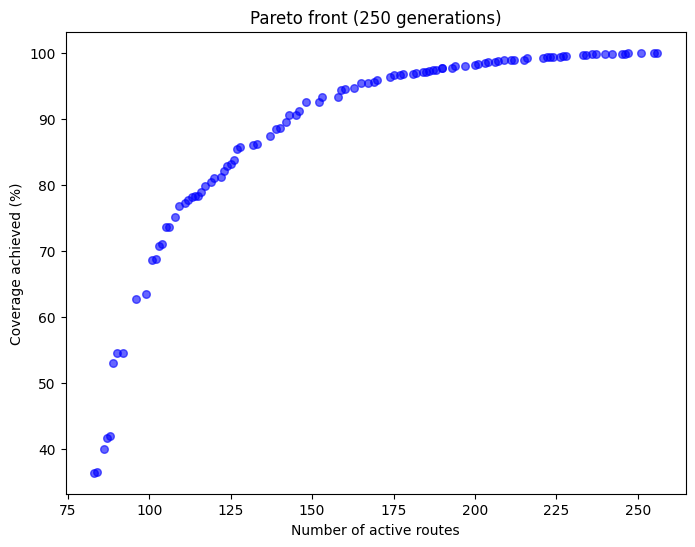

In [9]:
res1 = minimize(problem, algorithm, get_termination("n_gen", 250), verbose=False)

# Plot Pareto front
plt.figure(figsize=(8, 6))
plt.scatter(res1.F[:, 0], res1.F[:, 1]*-1, color="blue", s=30, alpha=0.6)
plt.title("Pareto front (250 generations)")
plt.xlabel("Number of active routes")
plt.ylabel("Coverage achieved (%)")
plt.show()

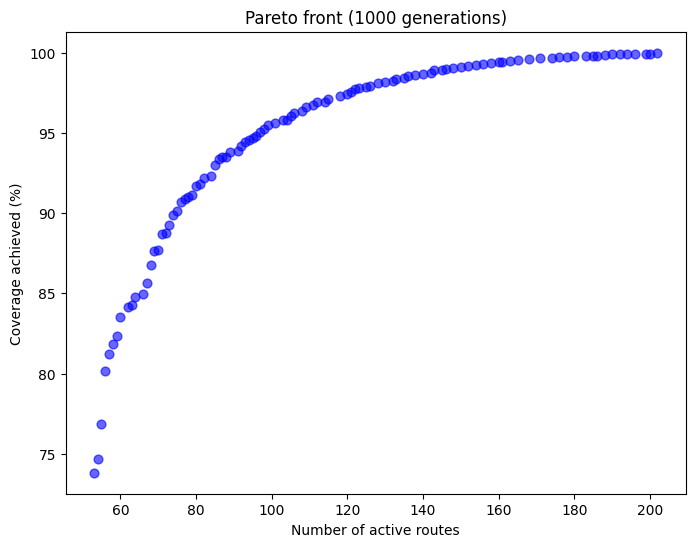

In [11]:
res2 = minimize(problem, algorithm, get_termination("n_gen", 1000), verbose=False)

# Plot Pareto front
plt.figure(figsize=(8, 6))
plt.scatter(res2.F[:, 0], res2.F[:, 1]*-1, color="blue", s=40, alpha=0.6)
plt.title("Pareto front (1000 generations)")
plt.xlabel("Number of active routes")
plt.ylabel("Coverage achieved (%)")
plt.show()

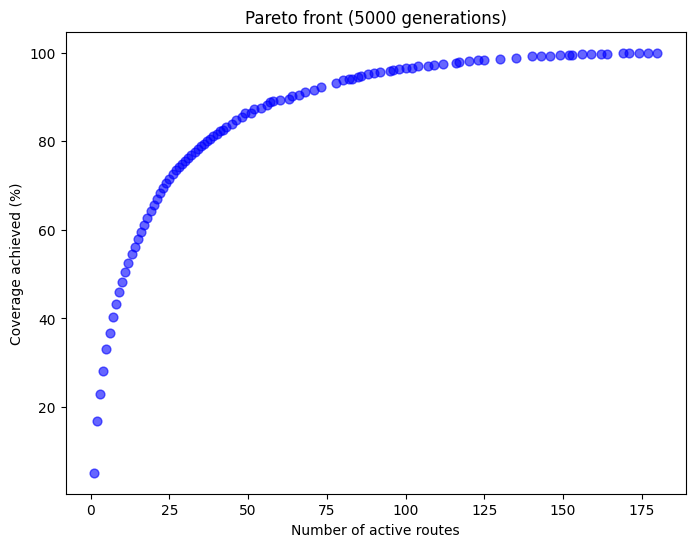

In [12]:
res3 = minimize(problem, algorithm, get_termination("n_gen", 5000), verbose=False)

# Plot Pareto front
plt.figure(figsize=(8, 6))
plt.scatter(res3.F[:, 0], res3.F[:, 1]*-1, color="blue", s=40, alpha=0.6)
plt.title("Pareto front (5000 generations)")
plt.xlabel("Number of active routes")
plt.ylabel("Coverage achieved (%)")
plt.show()

In [13]:
# Export results
res1_df = pd.DataFrame(res1.X, columns=['route' + str(i+1) for i in range(293)])
res1_df['active'] = res1.F[:, 0]
res1_df['coverage'] = res1.F[:, 1]*-1
res1_df['constraint'] = res1.G

res2_df = pd.DataFrame(res2.X, columns=['route' + str(i+1) for i in range(293)])
res2_df['active'] = res2.F[:, 0]
res2_df['coverage'] = res2.F[:, 1]*-1
res2_df['constraint'] = res2.G

res3_df = pd.DataFrame(res3.X, columns=['route' + str(i+1) for i in range(293)])
res3_df['active'] = res3.F[:, 0]
res3_df['coverage'] = res3.F[:, 1]*-1
res3_df['constraint'] = res3.G

In [14]:
# Save results
res1_df.to_csv('results_250.csv', index=False)
res2_df.to_csv('results_1000.csv', index=False)
res3_df.to_csv('results_5000.csv', index=False)